<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/02-linear-regression/LinearRegression_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Task 1 (3 points)

Consider the following toy dataset:

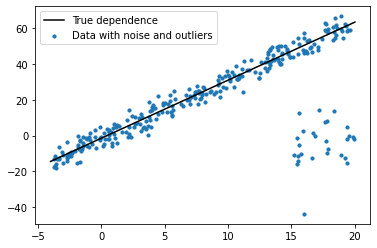

In [2]:
true_function = lambda x: 3.25 * x - 1.47
noize_function = lambda x: (
    np.random.normal(size=len(x)) * 4. +
    np.where(
        x < 15,
        0.,
        -60 + np.random.normal(size=len(x)) * 10
    ) * (np.random.uniform(size=len(x)) < 0.4).astype(int)
)
limits = (-4., 20.)

def generate_dataset(N=300):
  x = np.random.uniform(*limits, size=N)
  y = true_function(x) + noize_function(x)

  return x[:,None], y

X, y = generate_dataset()

x = np.linspace(*limits, 101)
plt.plot(x, true_function(x), c='black', label='True dependence')
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.legend();

Implement a linear model $\hat y(x|w) = w_1\cdot x + w_0$ with MAE loss:
$$\text{MAE}(w) = \frac{1}{N}\sum_{i=1}^N\left|y_i - \hat y(x_i|w)\right|,$$
using gradient descent optimization in `numpy`.

*Hint: introduce a constant feature to account for the bias term to make the formulas simpler.*

Plot the learning curve and the final fit. Also, fit the same data with `sklearn`'s `LinearRegression`, and compare the two fits on the same plot. What do you observe? Write a short comment.

#### Commet: for the exact example above, which is, a uniform part plus some noizes, MAE is a better approach than MSE (which is implemented in sklearn's LinearRegression model). There's no square term in MAE, so the loss function stay the same, with the same weight, which makes MAE less sensitive to outliers and more inclusive.

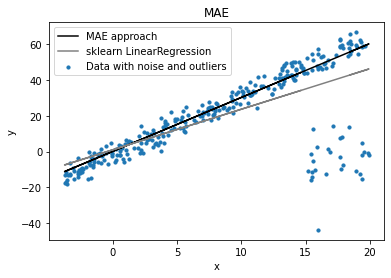

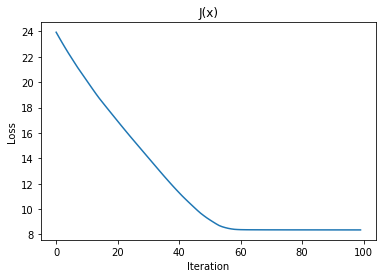

In [3]:
# fit, compare and loss function
X_one = np.vstack((np.ones_like(X.ravel()),X.ravel()))
N = X_one.shape[1]
Weight = np.zeros((1,2))
y_pred = np.dot(Weight, X_one)
num_iter = 100
learning_rate = 0.01
J = []

for i in range(num_iter):
   y_pred = np.dot(Weight,X_one)
   MAE_loss = np.mean(np.abs(y - y_pred))
   J.append(MAE_loss) # generate loss as a list
   Weight = Weight + learning_rate * 1/N * np.dot(np.sign(y - y_pred), X_one.T)

y_pred_MAE = np.dot(Weight, X_one).T


# compare LR in MSE
from sklearn.linear_model import LinearRegression

model_MSE = LinearRegression()
model_MSE.fit(X, y)
y_pred_MSE = model_MSE.predict(X)


plt.figure(0)
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(X, y_pred_MAE, c='black', label='MAE approach')
plt.plot(X, y_pred_MSE, c='grey', label= 'sklearn LinearRegression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('MAE')
plt.legend()

plt.figure(1)
plt.plot(J)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title("J(x)")
plt.show()


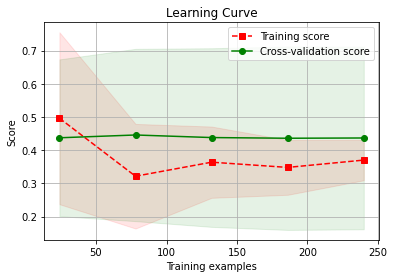

In [4]:
# learning curve
from sklearn.model_selection import train_test_split

# split train and cv
test_scores = np.zeros((10,5))
train_scores = np.zeros((10,5))
num_iter = 100
learning_rate = 0.01

# def y_column in Learning curve, which is R2
def score(y_true, y_pred):
    u = ((y_true - y_pred) ** 2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - u/v

# cross validation P-k-fold, P = 10, k = 5
for iter_cv in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    test_score = np.array([])
    train_score = np.array([])
    train_size = []
    for iter_learning in range(5):
        X_train_cv = X_train[0 : int(np.linspace(.1, 1.0, 5)[iter_learning] * len(X_train))]
        y_train_cv = y_train[0 : int(np.linspace(.1, 1.0, 5)[iter_learning] * len(y_train))]
        X_train_cv_one = np.vstack((np.ones_like(X_train_cv.ravel()),X_train_cv.ravel()))
        X_test_one = np.vstack((np.ones_like(X_test.ravel()),X_test.ravel()))
        
        # some parameters
        N = X_train_cv.shape[0]
        Weight = np.zeros((1,2))
        y_pred_cv = np.dot(Weight, X_train_cv_one)
       
        
        # find Weight using MAE
        for i in range(num_iter):
            y_pred_cv = np.dot(Weight,X_train_cv_one)
            Weight = Weight + learning_rate * 1/N * np.dot(np.sign(y_train_cv - y_pred_cv), X_train_cv_one.T)
        
        y_pred_test = np.dot(Weight, X_test_one)
        y_pred_cv = np.dot(Weight,X_train_cv_one)
        
        test_score = np.append(test_score, score(y_test, y_pred_test))
        train_score = np.append(train_score, score(y_train_cv, y_pred_cv))
        train_size.append(np.linspace(.1, 1.0, 5)[iter_learning] * len(X_train))
        
    test_scores[iter_cv] = test_score
    train_scores[iter_cv] = train_score

test_scores = test_scores.T
train_scores = train_scores.T

# plot
plt.figure()

plt.title("Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_size, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_size, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_size, train_scores_mean, 's--', color="r", label="Training score")
plt.plot(train_size, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
plt.legend(loc="best")
plt.show()


## Task 2 (2 + 1 points)

* Wrap your solution from the previous task into a class. Plot the learning curve and the final fit. Compare and comment your results with the previos ones. **(2 points)**

* Make it possible to choose a loss function. **(1 point)**

In [5]:
from sklearn.base import BaseEstimator, RegressorMixin

In [7]:
# for SGD, sklearn.linear_model.SGDRegressor has already had such functions and the ability to choose a loss function in 
# Parameters:	loss : str, ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’ 
# for the continuity of former works, the following will keep using Gradient descent as an optimization.
class LinearRergessionSGD(BaseEstimator, RegressorMixin):
    def __init__(self):
        raise NotImplementedError

    def fit(self, x, y):
        raise NotImplementedError

    def predict(self, x):
        raise NotImplementedError
    
    def fit_predict(self, x, y):
        raise NotImplementedError

In [8]:
# warp LR, MAE approach only
class LinearRergessionMAE(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self.Weight = np.zeros((1,2))

    def fit(self, x, y):
        x = np.vstack((np.ones_like(x.ravel()),x.ravel()))
        for i in range(100):
            y_pred = np.dot(self.Weight,x)
            self.Weight = self.Weight + 0.01 * 1/x.shape[1] * np.dot(np.sign(y - y_pred), x.T)
        self.coef_ = self.Weight[0][:-1]
        self.intercept_ = self.Weight[0][-1]

    def predict(self, x):
        x = np.vstack((np.ones_like(x.ravel()),x.ravel()))
        return np.dot(self.Weight, x).T

    def fit_predict(self, x, y):
        # why fit_predict() in linear regression...
        x = np.vstack((np.ones_like(x.ravel()),x.ravel()))
        for i in range(100):
            y_pred = np.dot(self.Weight,x)
            MAE_loss = np.mean(np.abs(y - y_pred))
            J.append(MAE_loss)
            self.Weight = self.Weight + 0.01 * 1/x.shape[1] * np.dot(np.sign(y - y_pred), x.T)
        return np.dot(self.Weight, x).T


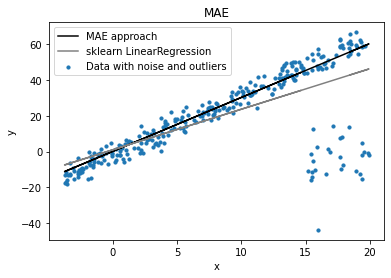

In [9]:
# fit and plot, comparism with MSE
model_MAE = LinearRergessionMAE()
model_MAE.fit(X, y)
y_pred_MAE = model_MAE.predict(X)

plt.figure()
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(X, y_pred_MAE, c='black', label='MAE approach')
plt.plot(X, y_pred_MSE, c='grey', label= 'sklearn LinearRegression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('MAE')
plt.legend()

In [10]:
# modified from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='r2', train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 's--', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt


#### Commet: I would say that wrap into a class makes your code more understandable, and more easily to connect with other livraries, which is the usage of conceptualization.

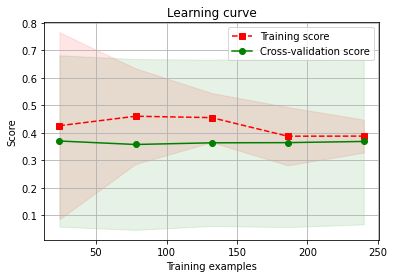

In [11]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

plt.figure()
plot_learning_curve(model_MAE, "Learning curve", X, y, cv=cv)
plt.show()

In [12]:
# more loss functions
class LinearRergession(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        self.Weight = np.zeros((1,2))
        
    def loss_MAE(self, x, y, y_pred):
        return self.Weight + 0.01 * 1/x.shape[1] * np.dot(np.sign(y - y_pred), x.T)
    
    def loss_MSE(self, x, y, y_pred):
        return self.Weight + 0.001 * 2/x.shape[1] * np.dot((y - y_pred), x.T)

    def fit(self, x, y, loss):
        x = np.vstack((np.ones_like(x.ravel()),x.ravel()))
        for i in range(100):
            y_pred = np.dot(self.Weight,x)
            self.Weight = self.loss_MAE(x, y, y_pred) if loss == "MAE" else self.Weight
            self.Weight = self.loss_MSE(x, y, y_pred) if loss == "MSE" else self.Weight
        self.coef_ = self.Weight[0][:-1]
        self.intercept_ = self.Weight[0][-1]

    def predict(self, x):
        x = np.vstack((np.ones_like(x.ravel()),x.ravel()))
        return np.dot(self.Weight, x).T

    def fit_predict(self, x, y):
        # why fit_predict() in linear regression...
        x = np.vstack((np.ones_like(x.ravel()),x.ravel()))
        for i in range(100):
            y_pred = np.dot(self.Weight,x)
            MAE_loss = np.mean(np.abs(y - y_pred))
            J.append(MAE_loss)
            self.Weight = self.Weight + 0.01 * 1/x.shape[1] * np.dot(np.sign(y - y_pred), x.T)
        return np.dot(self.Weight, x).T


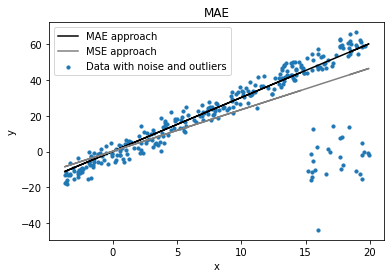

In [13]:
# plot
model_MAE = LinearRergession()
model_MAE.fit(X, y,"MAE")
y_pred_MAE = model_MAE.predict(X)

model_MSE = LinearRergession()
model_MSE.fit(X, y,"MSE")
y_pred_MSE = model_MSE.predict(X)

plt.figure()
plt.scatter(X, y, s=10, label='Data with noise and outliers')
plt.plot(X, y_pred_MAE, c='black', label='MAE approach')
plt.plot(X, y_pred_MSE, c='grey', label= 'MSE approach')
plt.xlabel('x')
plt.ylabel('y')
plt.title('MAE')
plt.legend()